# Ternary plots for vanilla classifiers

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.ops import onehot_encode
from utils.data import get_cifar3, get_cifarn
from utils.metrics import neg_log_likelihood, accuracy, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram
from calibrators import PAVCalibrator, NiceCalibrator, TempScalingCalibrator

In [4]:
%matplotlib inline

## Load IRIS dataset

In [5]:
iris = load_iris()
ix2label = {
    0: 'Setosa',
    1: 'Versicolour',
    2: 'Virginica'}

There are 50 samples per class, we can take 15 of each to form a validation set. Samples come ordered by class, the first 50 are class-0 samples, etc..

In [6]:
n_samples_class = 30

idxs0, idxs1, idxs2 = np.random.permutation(50), np.random.permutation(50)+50, np.random.permutation(50)+100

X_train = np.vstack((iris.data[idxs0[:n_samples_class], :],
                     iris.data[idxs1[:n_samples_class], :],
                     iris.data[idxs2[:n_samples_class], :]))
y_train = np.hstack((iris.target[idxs0[:n_samples_class]], iris.target[idxs1[:n_samples_class]], iris.target[idxs2[:n_samples_class]]))

X_test = np.vstack((iris.data[idxs0[n_samples_class:], :],
                    iris.data[idxs1[n_samples_class:], :],
                    iris.data[idxs2[n_samples_class:], :]))
y_test = np.hstack((iris.target[idxs0[n_samples_class:]], iris.target[idxs1[n_samples_class:]], iris.target[idxs2[n_samples_class:]]))

### Train a SVM

In [7]:
svc = SVC(kernel='rbf', probability=True);
svc.fit(X_train, y_train);

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [8]:
# Performance
print("Accuracy: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on the test set: {:.3f}".format(svc.score(X_test, y_test)))

probs = svc.predict_proba(X_train)
probs_test = svc.predict_proba(X_test)
print("Cross-entropy: {:.3f}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {:.3f}".format(neg_log_likelihood(probs_test, y_test)))

Accuracy: 0.956
Accuracy on the test set: 0.983
Cross-entropy: 0.107
Cross-entropy on the test set: 0.107


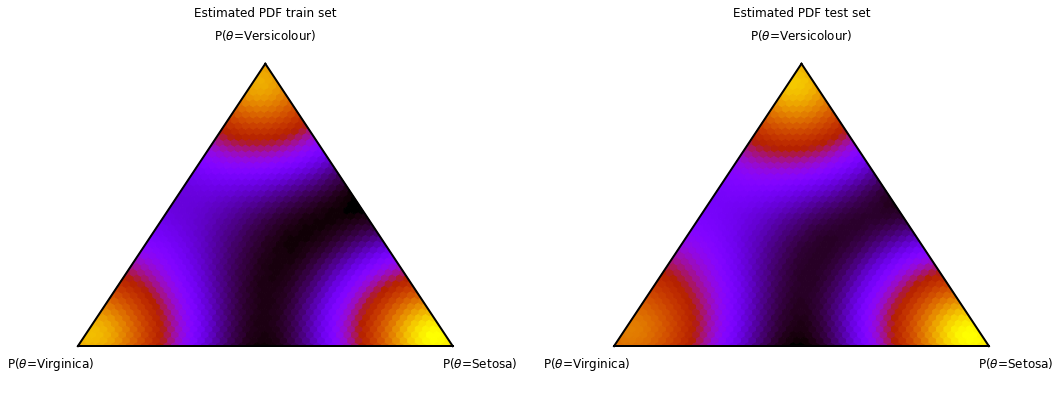

In [9]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(probs_test, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects 

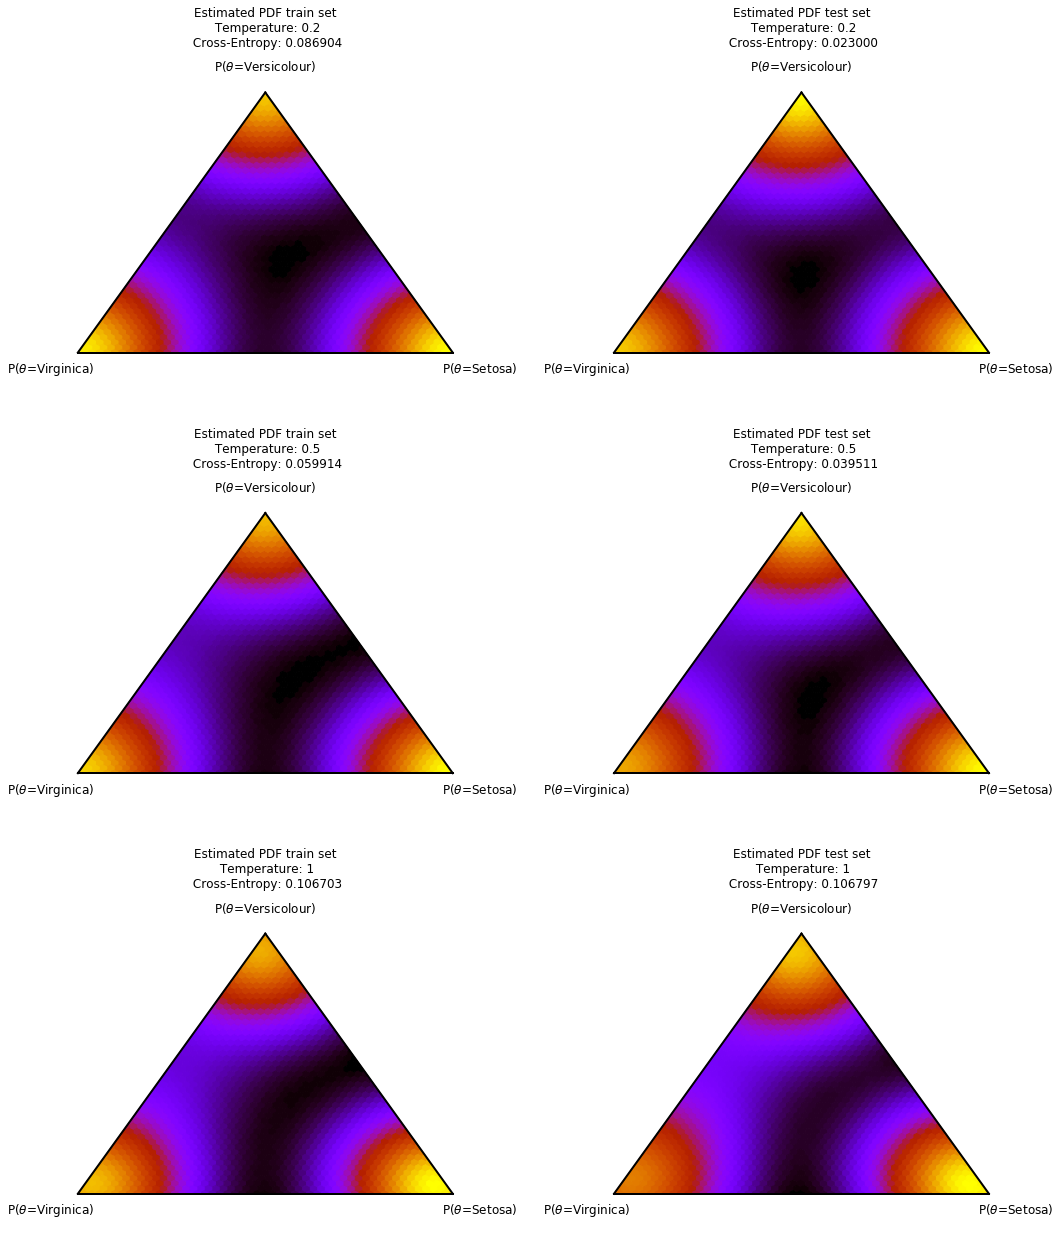

In [10]:
train_logits = svc.predict_log_proba(X_train)
test_logits = svc.predict_log_proba(X_test)

Ts = [0.2, 0.5, 1]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_simplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_simplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

### Optimum temperature

In [11]:
def optim_temperature(logits, target, min_diff=1e-5, step=0.1):
    T = 1.0
    probs = softmax(logits/T, axis=1)

    while True:
        # Compute gradient w.r.t. T
        one_hot = onehot_encode(target)
        grad = -np.mean(np.sum((probs-one_hot)*logits/T**2, axis=1))

        # Update step
        probs_new = softmax(logits/(T-grad*step), axis=1)

        if abs(grad*step) < min_diff:
            break

        T -= grad*step
        probs = probs_new

    return T

In [12]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.502
 achieves LNN=0.040 on test set
Optimum temperature for test set: 0.132
 achieves LNN=0.021 on test set


### Load CIFAR-3

In [13]:
data_path = '../cifar-10'
cifar3, ix2label = get_cifarn(data_path, target_labels=['airplane', 'automobile', 'bird'], test=True)

### Train a simple classifier: PCA+Logistic

In [14]:
# Hyperparameters
n_components = 20

In [15]:
# Prepare data
y_train = cifar3['labels']
X_train = np.array([ima.flatten() for ima in cifar3['images']])

y_test = cifar3['test_labels']
X_test = np.array([ima.flatten() for ima in cifar3['test_images']])

In [16]:
# Fit PCA
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [17]:
# Train LogisticRegression
t0 = time.time()
logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train_pca, y_train)
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 0.033s


In [18]:
# Train and test performance
print("Accuracy on the train set: {}".format(logistic.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(logistic.score(X_test_pca, y_test)))

probs = logistic.predict_proba(X_train_pca)
test_probs = logistic.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.6864
Accuracy on the test set: 0.6793333333333333
Cross-entropy on the train set: 0.7750072201009975
Cross-entropy on the test set: 0.764430798222871


## Visualizing results 

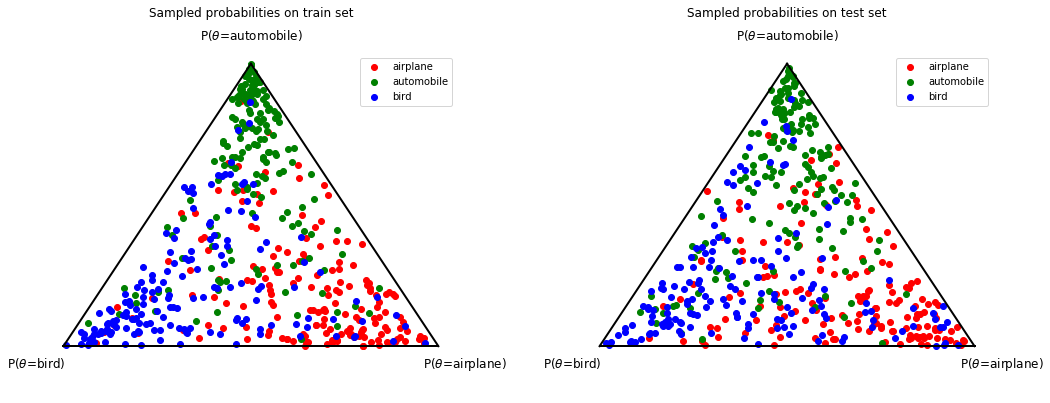

In [19]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_prob_simplex(probs[:500], target=y_train[:500], ax=ax_arr[0],
                              title='Sampled probabilities on train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_prob_simplex(test_probs[:500], target=y_test[:500], ax=ax_arr[1],
                              title='Sampled probabilities on test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

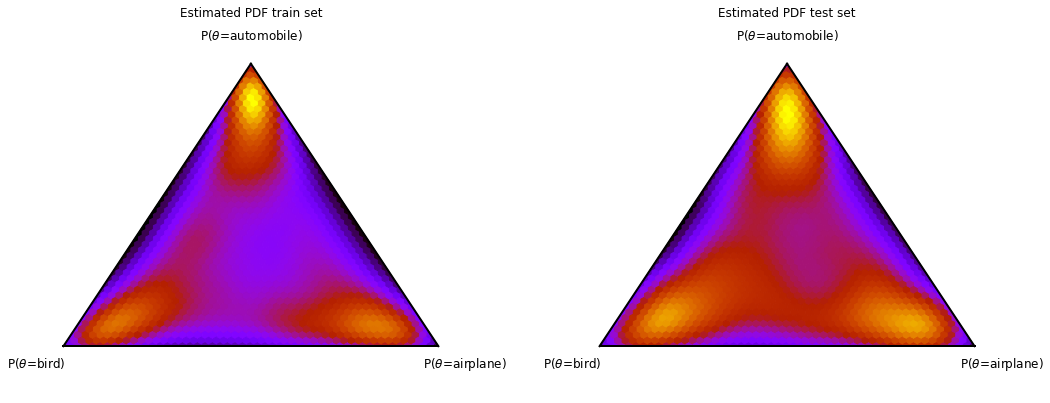

In [20]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Temperature Scaling effects

In [21]:
train_logits = logistic.predict_log_proba(X_train_pca)
test_logits = logistic.predict_log_proba(X_test_pca)

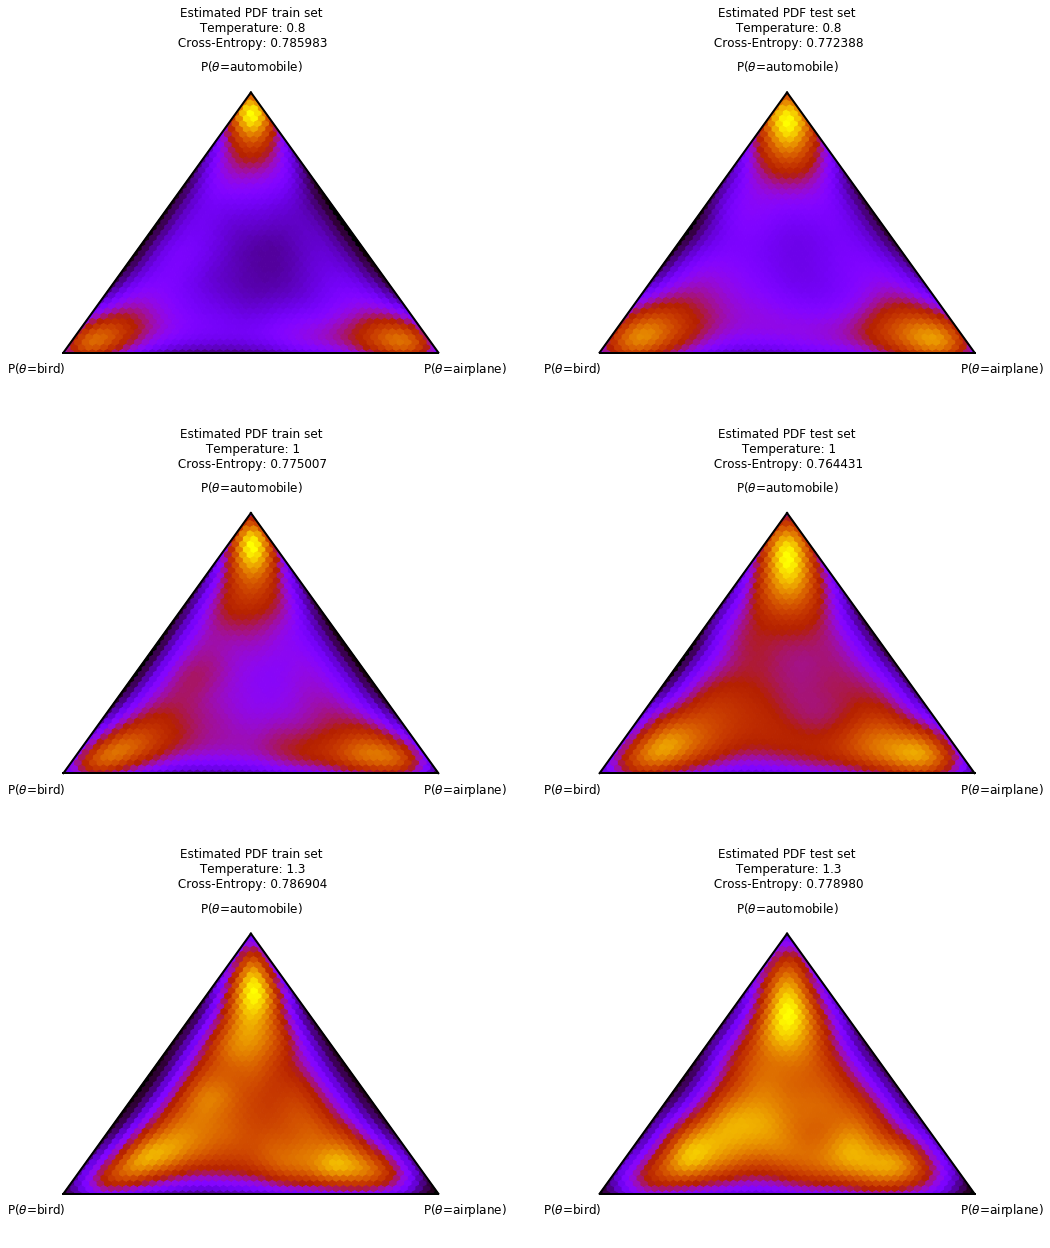

In [22]:
Ts = [0.8, 1, 1.3]
fig, ax_arr = plt.subplots(len(Ts), 2, figsize=(17, 7*len(Ts)), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, T in enumerate(Ts):
    train_probs = softmax(train_logits/T, axis=1)
    test_probs = softmax(test_logits/T, axis=1)
    train_xentropy = neg_log_likelihood(train_probs, y_train)
    test_xentropy = neg_log_likelihood(test_probs, y_test)
    
    ax_arr[i, 0] = plot_pdf_simplex(train_probs, ax=ax_arr[i, 0],
                                 title='Estimated PDF train set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, train_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
    ax_arr[i, 1] = plot_pdf_simplex(test_probs, ax=ax_arr[i, 1],
                                 title='Estimated PDF test set\n Temperature: {}\n Cross-Entropy: {:3f}'.format(T, test_xentropy),
                                 fontsize=12, labels=list(ix2label.values()));
plt.show()

In [23]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 1.000
 achieves LNN=0.764 on test set
Optimum temperature for test set: 0.970
 achieves LNN=0.764 on test set


## PCA + SVMLinear

In [24]:
# Train SVM
t0 = time.time()
svc = SVC(kernel='linear', probability=True);
svc.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

Fitted in 62.075s


In [25]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc.score(X_test_pca, y_test)))

probs = svc.predict_proba(X_train_pca)
test_probs = svc.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.6913333333333334
Accuracy on the test set: 0.6823333333333333
Cross-entropy on the train set: 0.7705172146093568
Cross-entropy on the test set: 0.7600206018048663


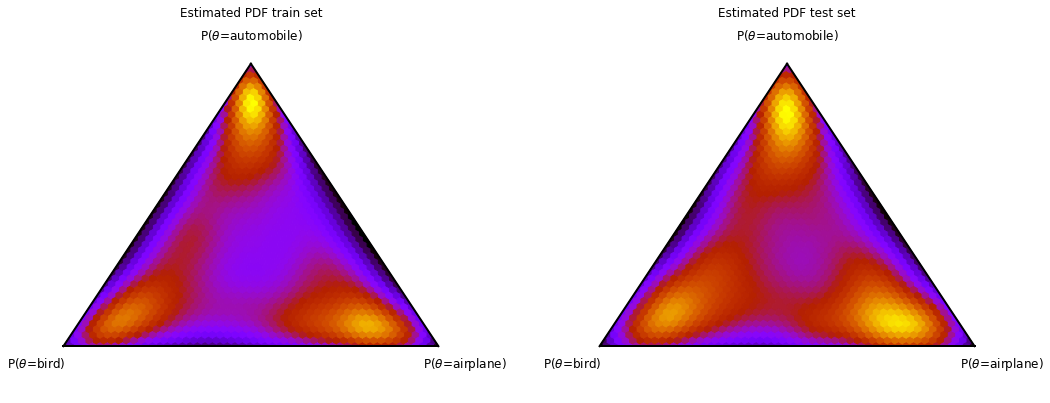

In [26]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [27]:
train_logits = svc.predict_log_proba(X_train_pca)
test_logits = svc.predict_log_proba(X_test_pca)

In [28]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.959
 achieves LNN=0.759 on test set
Optimum temperature for test set: 0.930
 achieves LNN=0.759 on test set


## PCA + SVMPolynomial

In [29]:
# Train SVM
t0 = time.time()
svc_poly = SVC(kernel='poly', degree=2, probability=True);
svc_poly.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 27.654s


In [30]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_poly.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_poly.score(X_test_pca, y_test)))

probs = svc_poly.predict_proba(X_train_pca)
test_probs = svc_poly.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7178666666666667
Accuracy on the test set: 0.708
Cross-entropy on the train set: 0.6979317518654293
Cross-entropy on the test set: 0.71716478655355


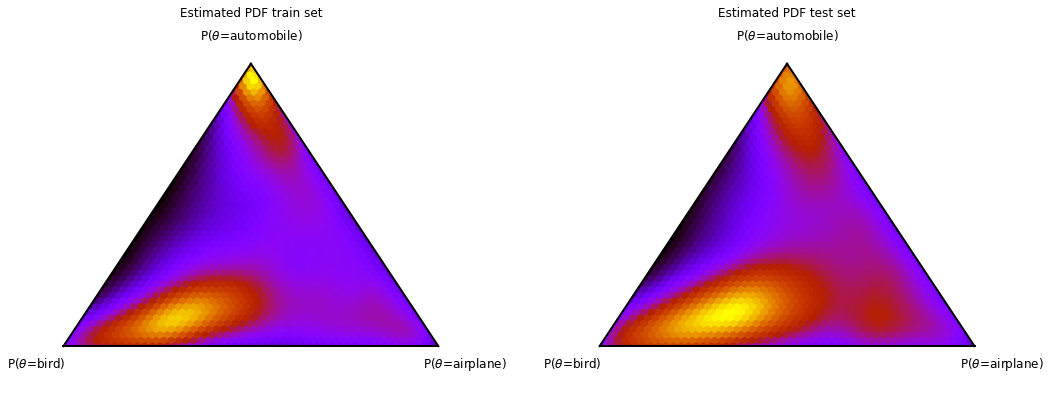

In [31]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [32]:
train_logits = svc_poly.predict_log_proba(X_train_pca)
test_logits = svc_poly.predict_log_proba(X_test_pca)

In [33]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.887
 achieves LNN=0.717 on test set
Optimum temperature for test set: 0.942
 achieves LNN=0.717 on test set


## PCA + SVMrbf 

In [34]:
# Train SVM
t0 = time.time()
svc_rbf = SVC(kernel='rbf', probability=True);
svc_rbf.fit(X_train_pca, y_train);
print("Fitted in {:.3f}s".format(time.time() - t0))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitted in 34.138s


In [35]:
# Train and test performance
print("Accuracy on the train set: {}".format(svc_rbf.score(X_train_pca, y_train)))
print("Accuracy on the test set: {}".format(svc_rbf.score(X_test_pca, y_test)))

probs = svc_rbf.predict_proba(X_train_pca)
test_probs = svc_rbf.predict_proba(X_test_pca)
print("Cross-entropy on the train set: {}".format(neg_log_likelihood(probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.8552
Accuracy on the test set: 0.804
Cross-entropy on the train set: 0.38953834227129336
Cross-entropy on the test set: 0.49397735264016396


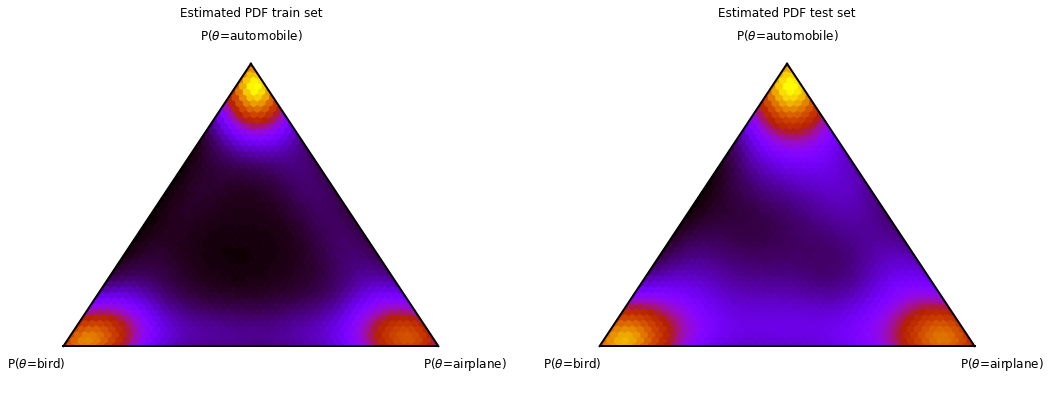

In [36]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

In [37]:
train_logits = svc_rbf.predict_log_proba(X_train_pca)
test_logits = svc_rbf.predict_log_proba(X_test_pca)

In [38]:
T_train = optim_temperature(train_logits, y_train)
T_test = optim_temperature(test_logits, y_test)

test_probs_train = softmax(test_logits/T_train, axis=1)
test_xentropy_train = neg_log_likelihood(test_probs_train, y_test)

test_probs_test = softmax(test_logits/T_test, axis=1)
test_xentropy_test = neg_log_likelihood(test_probs_test, y_test)

print("Optimum temperature for train set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_train, test_xentropy_train))
print("Optimum temperature for test set: {:.3f}\n achieves LNN={:.3f} on test set".format(T_test, test_xentropy_test))

Optimum temperature for train set: 0.810
 achieves LNN=0.503 on test set
Optimum temperature for test set: 0.984
 achieves LNN=0.494 on test set


# SmallCNN

In [39]:
cnn_path = '../pretrained-models/cnn_cifar'

In [40]:
model = tf.keras.models.load_model(os.path.join(cnn_path, 'model.h5'), custom_objects={'tf': tf})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [41]:
# Compute predictions
train_probs = model.predict(cifar3['images']/255.)
test_probs = model.predict(cifar3['test_images']/255.)

In [42]:
# Train and test performance
print("Accuracy on the train set: {}".format(accuracy(train_probs, y_train)))
print("Accuracy on the test set: {}".format(accuracy(test_probs, y_test)))


print("Cross-entropy on the train set: {}".format(neg_log_likelihood(train_probs, y_train)))
print("Cross-entropy on the test set: {}".format(neg_log_likelihood(test_probs, y_test)))

Accuracy on the train set: 0.7047333333333333
Accuracy on the test set: 0.7186666666666667
Cross-entropy on the train set: 0.7440231508267422
Cross-entropy on the test set: 0.7312376976441592


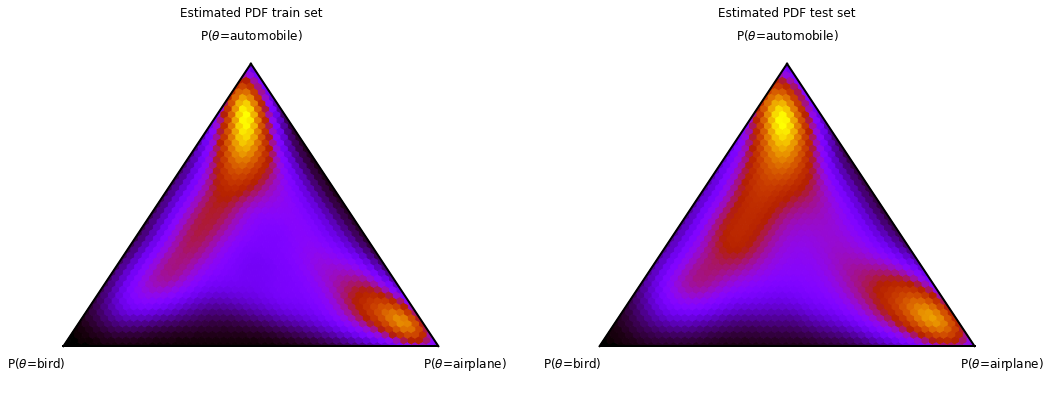

In [43]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(train_probs, ax=ax_arr[0], title='Estimated PDF train set', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(test_probs, ax=ax_arr[1], title='Estimated PDF test set', fontsize=12, labels=list(ix2label.values()));
plt.show()

### Visualizing misscalibration

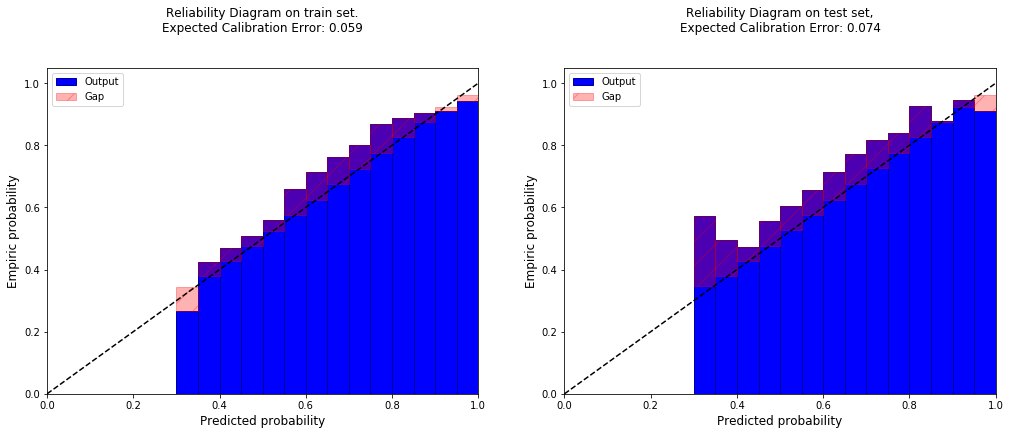

In [44]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = reliability_diagram(train_probs, y_train, ax=ax_arr[0], title='Reliability Diagram on train set.'+
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(train_probs, y_train)))
ax_arr[1] = reliability_diagram(test_probs, y_test, ax=ax_arr[1], title='Reliability Diagram on test set,' + 
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(test_probs, y_test)))
plt.show();

## Calibrating cnn
### Obtain the logits

In [45]:
logits = np.log(model.predict(cifar3['test_images']/255.).astype(np.float))
target = onehot_encode(y_test.astype(np.int))

### Temperature Scaling 

In [46]:
# Temp scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print("Optimal temperature found: {:.3f}, elapsed time: {:.3f}s".format(temp_cal.T, (time.time()-t0)))
temp_probs = temp_cal.predict(logits)

temp_nll = neg_log_likelihood(temp_probs, target)
temp_acc = accuracy(temp_probs, target)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(temp_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(temp_acc))

Optimal temperature found: 0.807, elapsed time: 0.063s
Negative log-likelihood after calibration with temp-scaling: 0.722
Accuracy after calibration with temp-scaling: 0.719


Effect on simplex:

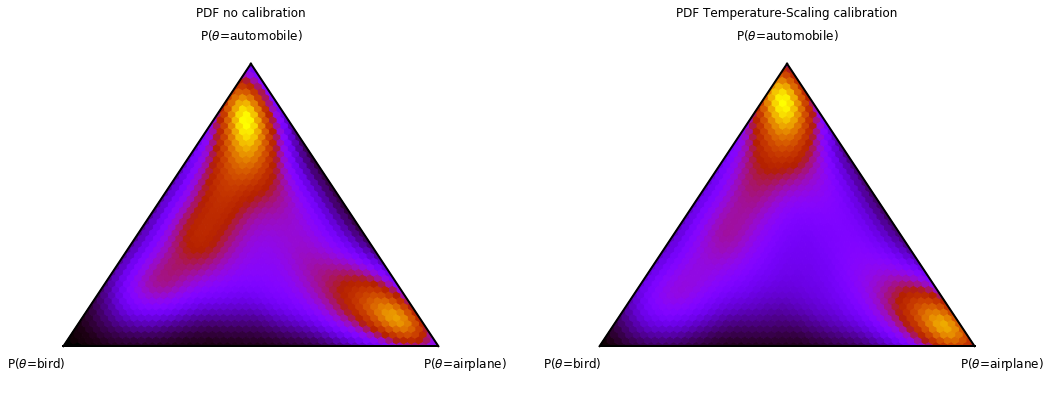

In [47]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(temp_probs, ax=ax_arr[1], title='PDF Temperature-Scaling calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

Effect on reliability diagram:

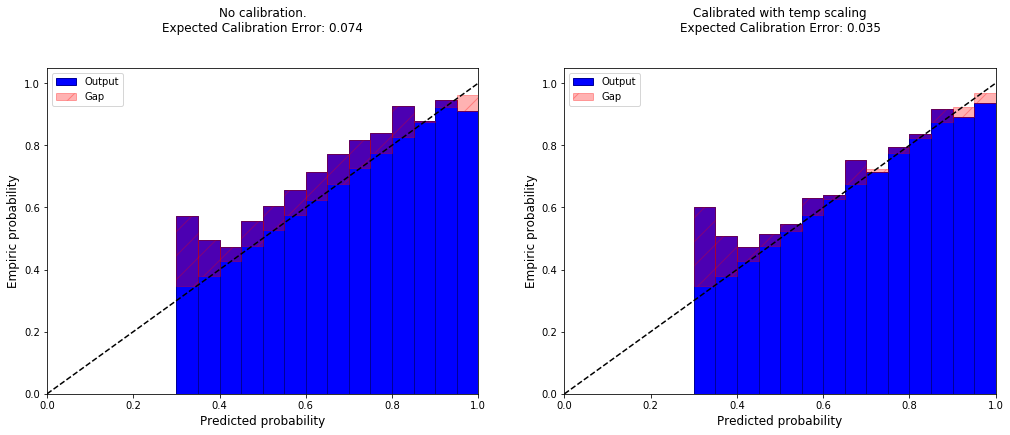

In [48]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = reliability_diagram(test_probs, y_test, ax=ax_arr[0], title='No calibration.'+
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(test_probs, y_test)))
ax_arr[1] = reliability_diagram(temp_probs, y_test, ax=ax_arr[1], title='Calibrated with temp scaling' + 
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(temp_probs, y_test)))
plt.show();

### PAV calibration 

In [49]:
t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print("PAV calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

PAV calibration fitted, elapsed time: 0.003s


In [50]:
pav_probs = pav_cal.predict(logits.astype(np.float))

pav_nll = neg_log_likelihood(pav_probs, y_test)
pav_acc = accuracy(pav_probs, y_test)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(pav_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(pav_acc))

Negative log-likelihood after calibration with temp-scaling: 0.633
Accuracy after calibration with temp-scaling: 0.754


Effects on probability simplex:

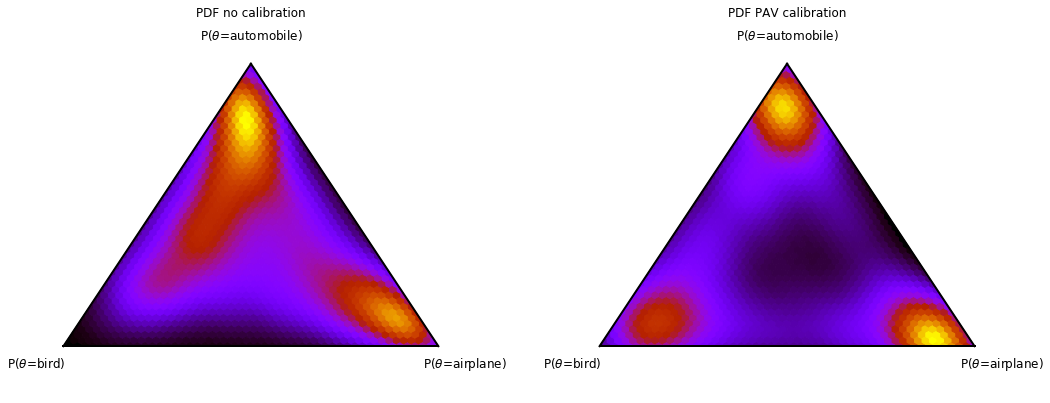

In [51]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(pav_probs, ax=ax_arr[1], title='PDF PAV calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

Effect on reliability diagram:

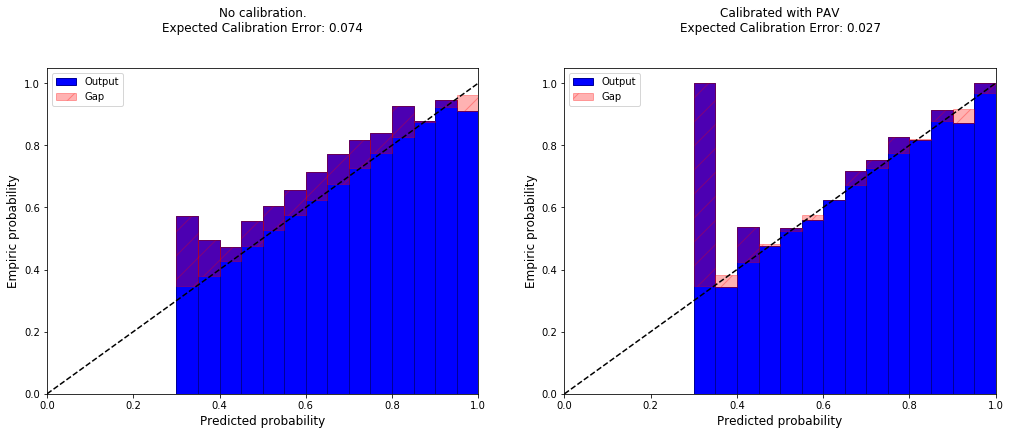

In [52]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = reliability_diagram(test_probs, y_test, ax=ax_arr[0], title='No calibration.'+
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(test_probs, y_test)))
ax_arr[1] = reliability_diagram(pav_probs, y_test, ax=ax_arr[1], title='Calibrated with PAV' + 
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(pav_probs, y_test)))
plt.show();

### NICE calibration

In [53]:
t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=6,
                          hidden_size=[5, 5], epochs=1000, batch_size=100)
print("NICE-flow calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow calibration fitted, elapsed time: 164.679s


In [54]:
t0 = time.time()
nice_cal_v2 = NiceCalibrator(logits, target, version=2, layers=6,
                          hidden_size=[5, 5], epochs=1000, batch_size=100)
print("NICE-flow-v2 calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

NICE-flow-v2 calibration fitted, elapsed time: 176.744s


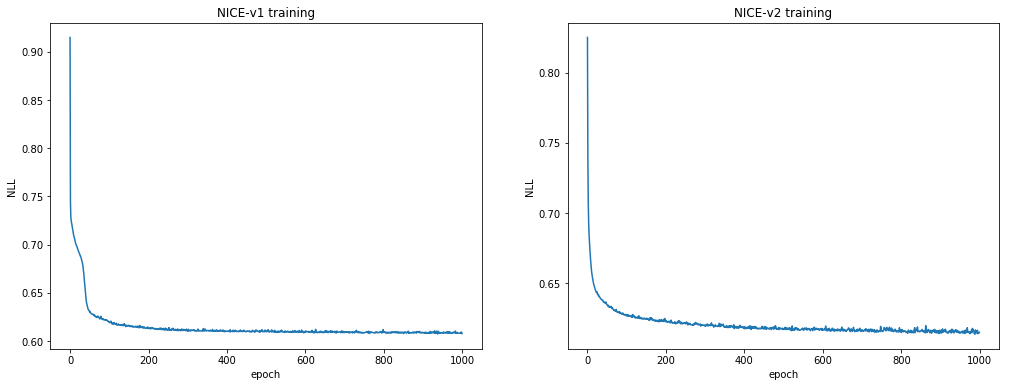

In [55]:
# Visalize training
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0].plot(nice_cal.history.history['loss'])
ax_arr[0].set_title('NICE-v1 training')
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('epoch')

ax_arr[1].plot(nice_cal_v2.history.history['loss'])
ax_arr[1].set_title('NICE-v2 training')
ax_arr[1].set_ylabel('NLL')
ax_arr[1].set_xlabel('epoch')

plt.show()

In [56]:
nice_probs = nice_cal.predict(logits)

nll_nice = neg_log_likelihood(nice_probs, y_test)
nice_acc = accuracy(nice_probs, y_test)

print("Negative log-likelihood after calibration with NICEv1: {:.3f}".format(nll_nice))
print("Accuracy after calibration with NICEv1: {:.3f}".format(nice_acc))

## V2
nice_probs_v2 = nice_cal_v2.predict(logits)

nll_nice_v2 = neg_log_likelihood(nice_probs_v2, y_test)
nice_acc_v2 = accuracy(nice_probs_v2, y_test)

print("Negative log-likelihood after calibration with NICEv2: {:.3f}".format(nll_nice_v2))
print("Accuracy after calibration with NICEv2: {:.3f}".format(nice_acc_v2))

Negative log-likelihood after calibration with NICEv1: 0.608
Accuracy after calibration with NICEv1: 0.754
Negative log-likelihood after calibration with NICEv2: 0.615
Accuracy after calibration with NICEv2: 0.758


Effects on probability simplex:

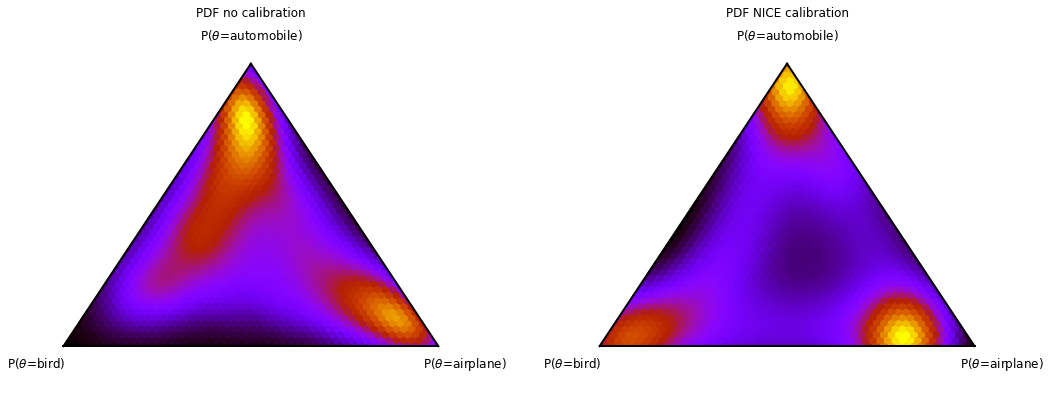

In [57]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0] = plot_pdf_simplex(test_probs, ax=ax_arr[0], title='PDF no calibration', fontsize=12, labels=list(ix2label.values()));
ax_arr[1] = plot_pdf_simplex(nice_probs, ax=ax_arr[1], title='PDF NICE calibration', fontsize=12, labels=list(ix2label.values()));
plt.show()

Effects on reliability diagram:

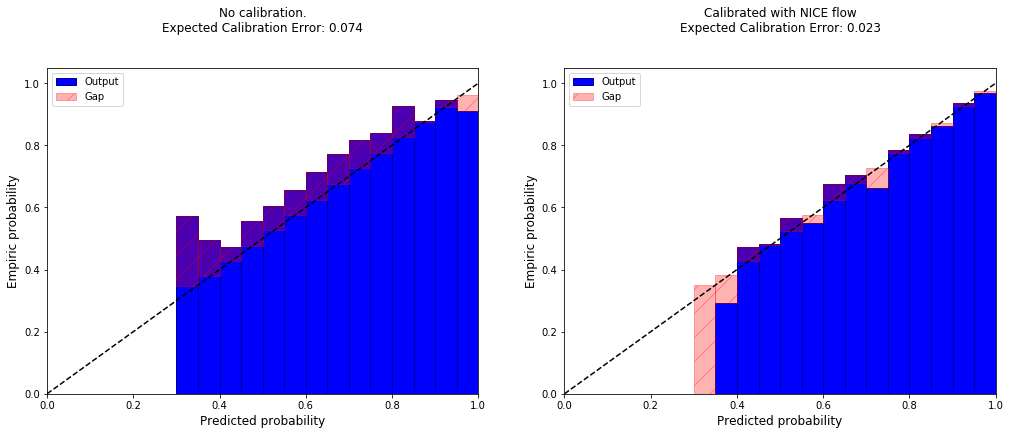

In [58]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = reliability_diagram(test_probs, y_test, ax=ax_arr[0], title='No calibration.'+
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(test_probs, y_test)))
ax_arr[1] = reliability_diagram(nice_probs, y_test, ax=ax_arr[1], title='Calibrated with NICE flow' + 
                                '\nExpected Calibration Error: {:.3f}'.format(expected_calibration_error(nice_probs, y_test)))
plt.show();